<a href="https://colab.research.google.com/github/propulsionsystem/HPRE/blob/main/IITBRT_hybridrocketmotor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary motor design

lets say we want uniform thrust of 100N for 10 seconds

In [ ]:
F = 100
tb = 10 # seconds (burn time)
# F = m_dot_total * Isp * g0
g0 = 9.8

# lets say we operate the n2o/paraffin motor at OF ratio = 8
# thus

Isp = 300 # seconds according to the Isp v/s O/F ratio chart given below

m_flux_total = F / (Isp *g0)
print(f"Total mass flow rate =  {m_flux_total}")

phi = 8 # O/F ratio

m_dot_fuel = m_flux_total / ( 1 + phi)
m_dot_ox = m_flux_total / (1 + 1/phi)

print(f"fuel mass flow rate = {m_dot_fuel * 1000} grams/second")
print(f"oxidiser mass flow rate = {m_dot_ox * 1000} grams/second")

m_f_total = m_dot_fuel * tb
m_ox_total = m_dot_ox * tb

print(f"fuel mass  = {m_f_total * 1000} grams")
print(f"oxidiser mass  = {m_ox_total * 1000} grams")

Total mass flow rate =  0.034013605442176874
fuel mass flow rate = 3.7792894935752086 grams/second
oxidiser mass flow rate = 30.23431594860167 grams/second
fuel mass  = 37.79289493575208 grams
oxidiser mass  = 302.34315948601665 grams


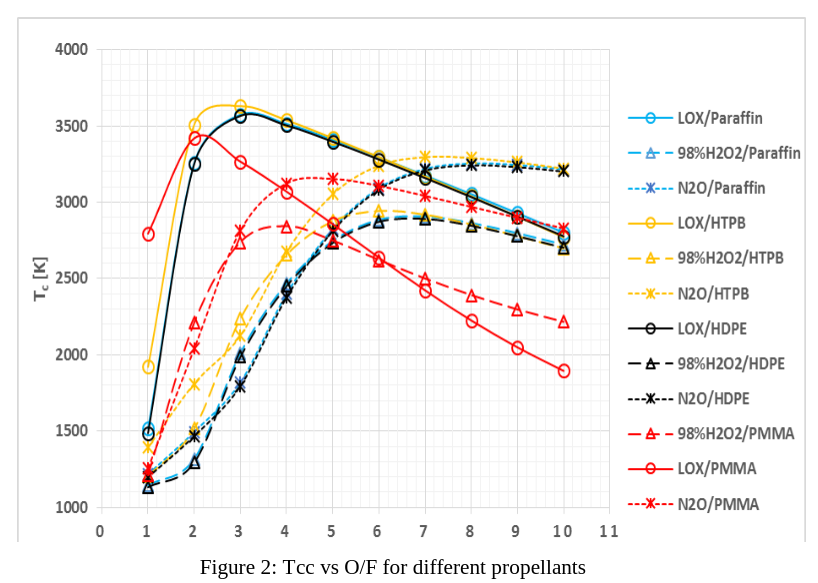

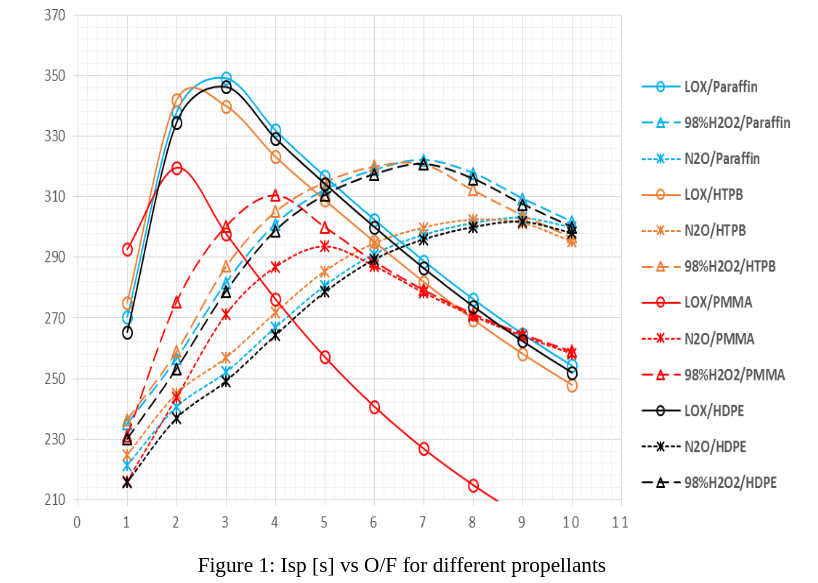

# N2O/paraffin

## Grain dimensions and mass flow rate of oxidiser decided here

In [ ]:
# CONSIDER THIS THE MAIN CODE

# temperature dependency captured
# edited the temperature data as well

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.interpolate import interp1d

# Constants (unchanged)
R, k, M, p1, p2 = 8.314, 1.33, 0.02897, 10e5, 1e5
a, n = 15.5e-2 / 1000, 0.5
d = 900  # Paraffin density

# N2O/Paraffin temperature vs O/F data (extracted from Figure 2)
OF_data = np.array([0.2, 1.0,  2.0,  3.0,  4.0 ,  6.0,  7.0,  8.0,  9.0,  10.0])
T_data = np.array([1000, 1210, 1500, 1800, 2400, 3100, 3200, 3260, 3250, 3200])  # Kelvin

# Create interpolation function for temperature vs O/F
temp_interpolator = interp1d(OF_data, T_data, kind='cubic',
                           bounds_error=False, fill_value=(T_data[0], T_data[-1]))

def get_temperature_from_OF(OF_ratio):
    """Get combustion temperature based on O/F ratio for N2O/Paraffin"""
    return float(temp_interpolator(OF_ratio))


def simulate_and_plot(r1_init, r2_val, l_val, mdot_ox):
    r1 = r1_init
    r2 = r2_val
    l = l_val
    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0

    # Storage arrays
    t, F, r, OF_ratio, dr_values, r_dot_values, T_values = [], [], [], [], [], [], []

    # Time loop
    while r1 <= r2:
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n
        r_dot = a * G_ox**n
        mdot_f = 2 * pi * l * d * r1 * dr / dt

        # Calculate O/F ratio first
        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0  # Avoid division by zero

        # Get temperature based on current O/F ratio
        T1 = get_temperature_from_OF(OF)

        # Calculate velocity and thrust with updated temperature
        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        # Save
        t.append(t_current)
        F.append(thrust)
        r.append(r1)
        OF_ratio.append(OF)
        dr_values.append(dr)
        r_dot_values.append(r_dot)
        T_values.append(T1)
        mox += mdot_ox * dt
        mfuel += mdot_f * dt

        r1 += dr
        t_current += dt

    m_propellant = mox + mfuel
    g = 9.81  # m/s²
    final_thrust = F[-1]
    tw_ratio = final_thrust / (m_propellant * g) if m_propellant > 0 else 0

    print(f"Total oxidiser consumed: {mox:.3f} kg")
    print(f"Total fuel consumed: {mfuel:.3f} kg")
    print(f"Total propellant mass: {m_propellant:.3f} kg")
    print(f"Final O/F ratio: {OF_ratio[-1]:.2f}")
    print(f"Final combustion temperature: {T_values[-1]:.0f} K")
    print(f"Final Thrust: {final_thrust:.2f} N")
    print(f"T/W Ratio: {tw_ratio:.2f}")


    # Plotting in 3-column grid (2 rows, 3 columns)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    plots = [
        ("Thrust (N)", F),
        ("Radius (m)", r),
        ("OF Ratio", OF_ratio),
        ("Temperature (K)", T_values),
        ("dr (m)", dr_values),
        ("dr/dt (m/s)", r_dot_values)
    ]

    for ax, (label, data) in zip(axes.flat, plots):
        ax.plot(t, data, linewidth=2)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
        ax.set_title(label)

    plt.tight_layout()
    plt.show()


    # # Additional plot showing Temperature vs O/F relationship
    # fig2, ax2 = plt.subplots(figsize=(10, 6))
    # ax2.plot(OF_ratio, T_values, 'b-', linewidth=2, label='Simulation')
    # ax2.set_xlabel("O/F Ratio")
    # ax2.set_ylabel("Combustion Temperature (K)")
    # ax2.set_title("Combustion Temperature vs O/F Ratio During Burn")
    # ax2.grid(True, alpha=0.3)
    # ax2.legend()
    # plt.show()

# Sliders
r1_slider = widgets.FloatSlider(value=0.005, min=0.001, max=0.025, step=0.001,
                               description='r1 (m)', readout_format='.3f')
r2_slider = widgets.FloatSlider(value=0.01, min=0.001, max=0.05, step=0.001,
                               description='r2 (m)', readout_format='.3f')
l_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.3, step=0.01,
                              description='Length (m)', readout_format='.3f')
mdot_ox_slider = widgets.FloatSlider(value=0.044, min=0.0001, max=1.0, step=0.001,
                                    description='m_dot_ox (kg/s)', readout_format='.3f')

ui = widgets.VBox([r1_slider, r2_slider, l_slider, mdot_ox_slider])
out = widgets.Output()

def update_plot(change=None):
    with out:
        clear_output(wait=True)
        simulate_and_plot(r1_slider.value, r2_slider.value, l_slider.value, mdot_ox_slider.value)

# Attach callbacks
r1_slider.observe(update_plot, names='value')
r2_slider.observe(update_plot, names='value')
l_slider.observe(update_plot, names='value')
mdot_ox_slider.observe(update_plot, names='value')

# Initial display
display(ui, out)


Output()

In [ ]:
#oxidiser total available mass

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.interpolate import interp1d

# Constants (unchanged)
R, k, M, p1, p2 = 8.314, 1.33, 0.02897, 10e5, 1e5
a, n = 15.5e-2 / 1000, 0.5
d = 900  # Paraffin density

# N2O/Paraffin temperature vs O/F data (extracted from Figure 2)
OF_data = np.array([0.2, 1.0,  2.0,  3.0,  4.0 ,  6.0,  7.0,  8.0,  9.0,  10.0])
T_data = np.array([1000, 1210, 1500, 1800, 2400, 3100, 3200, 3260, 3250, 3200])  # Kelvin

# Create interpolation function
temp_interpolator = interp1d(OF_data, T_data, kind='cubic',
                             bounds_error=False, fill_value=(T_data[0], T_data[-1]))

def get_temperature_from_OF(OF_ratio):
    return float(temp_interpolator(OF_ratio))

def simulate_and_plot(r1_init, r2_val, l_val, mdot_ox, mox_available):
    r1 = r1_init
    r2 = r2_val
    l = l_val
    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0

    # Storage arrays
    t, F, r, OF_ratio, dr_values, r_dot_values, T_values = [], [], [], [], [], [], []

    # Time loop - run while there's still fuel port and oxidiser left
    while r1 <= r2 and mox <= mox_available:
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n
        r_dot = a * G_ox**n
        mdot_f = 2 * pi * l * d * r1 * dr / dt

        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)

        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        t.append(t_current)
        F.append(thrust)
        r.append(r1)
        OF_ratio.append(OF)
        dr_values.append(dr)
        r_dot_values.append(r_dot)
        T_values.append(T1)
        mox += mdot_ox * dt
        mfuel += mdot_f * dt

        r1 += dr
        t_current += dt

    m_propellant = mox + mfuel
    g = 9.81
    final_thrust = F[-1] if F else 0
    tw_ratio = final_thrust / (m_propellant * g) if m_propellant > 0 else 0
    # Compute total impulse
    total_impulse = sum(F) * dt if F else 0

    print(f"Total oxidiser consumed: {mox:.3f} kg")
    print(f"Total fuel consumed: {mfuel:.3f} kg")
    print(f"Total propellant mass: {m_propellant:.3f} kg")
    print(f"Final O/F ratio: {OF_ratio[-1]:.2f}" if OF_ratio else "No O/F data")
    print(f"Final combustion temperature: {T_values[-1]:.0f} K" if T_values else "No temp data")
    print(f"Final Thrust: {final_thrust:.2f} N")
    print(f"Total Impulse: {total_impulse:.2f} Ns")
    print(f"T/W Ratio: {tw_ratio:.2f}")

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    plots = [
        ("Thrust (N)", F),
        ("Radius (m)", r),
        ("OF Ratio", OF_ratio),
        ("Temperature (K)", T_values),
        ("dr (m)", dr_values),
        ("dr/dt (m/s)", r_dot_values)
    ]

    for ax, (label, data) in zip(axes.flat, plots):
        ax.plot(t, data, linewidth=2)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

# Sliders
r1_slider = widgets.FloatSlider(value=0.005, min=0.001, max=0.025, step=0.001,
                                description='r1 (m)', readout_format='.3f')
r2_slider = widgets.FloatSlider(value=0.01, min=0.001, max=0.05, step=0.001,
                                description='r2 (m)', readout_format='.3f')
l_slider = widgets.FloatSlider(value=0.04, min=0.01, max=0.3, step=0.001,
                               description='Length (m)', readout_format='.3f')
mdot_ox_slider = widgets.FloatSlider(value=0.008, min=0.0001, max=1.0, step=0.001,
                                     description='m_dot_ox (kg/s)', readout_format='.3f')
mox_total_slider = widgets.FloatSlider(value=0.008, min=0.001, max=5.0, step=0.001,
                                       description='Ox Mass (kg)', readout_format='.2f')

ui = widgets.VBox([r1_slider, r2_slider, l_slider, mdot_ox_slider, mox_total_slider])
out = widgets.Output()

def update_plot(change=None):
    with out:
        clear_output(wait=True)
        simulate_and_plot(
            r1_slider.value,
            r2_slider.value,
            l_slider.value,
            mdot_ox_slider.value,
            mox_total_slider.value
        )

# Attach callbacks
for slider in [r1_slider, r2_slider, l_slider, mdot_ox_slider, mox_total_slider]:
    slider.observe(update_plot, names='value')

# Initial display
display(ui, out)


Output()

optimum burn time:

✅ Best Burn Time Found:
-  r1       = 0.0020 m
-  l        = 0.0200 m
- mdot_ox  = 0.00407 kg/s
-  Burn Time = 1.967 s

Simulating with best parameters...
Total oxidiser consumed: 0.008 kg
Total fuel consumed: 0.001 kg
Total propellant mass: 0.009 kg
Final O/F ratio: 6.45
Final combustion temperature: 3155 K
Final Thrust: 8.38 N
Total Impulse: 16.48 Ns
T/W Ratio: 92.36

In [ ]:
m_system = 0.15 #kg
TW = 5

thrust = TW * m_system * 9.81
print(thrust)

7.3575


r1 = 0.0282 m, r2 = 0.0311 m, l = 0.0636 m, mdot_ox = 0.0687 kg/s
Max T = 3264.5 K, Prop Mass = 0.289 kg, T/W = 49.31


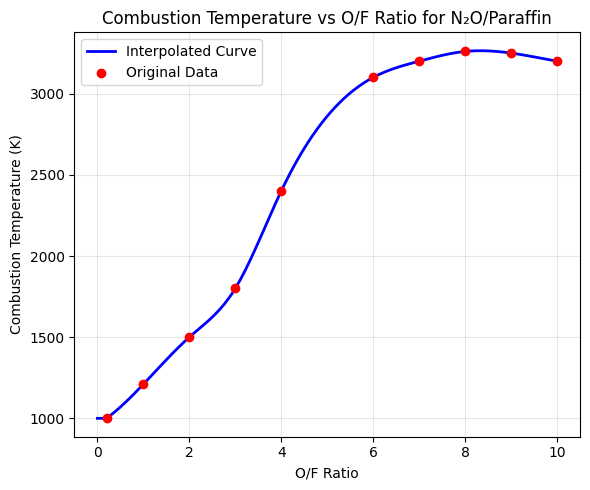

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# O/F data range to evaluate
OF_range = np.linspace(0, 10, 200)

# Use the interpolation function you already defined
T_range = temp_interpolator(OF_range)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(OF_range, T_range, 'b-', linewidth=2, label='Interpolated Curve')
plt.scatter(OF_data, T_data, color='red', zorder=5, label='Original Data')
plt.xlabel("O/F Ratio")
plt.ylabel("Combustion Temperature (K)")
plt.title("Combustion Temperature vs O/F Ratio for N₂O/Paraffin")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


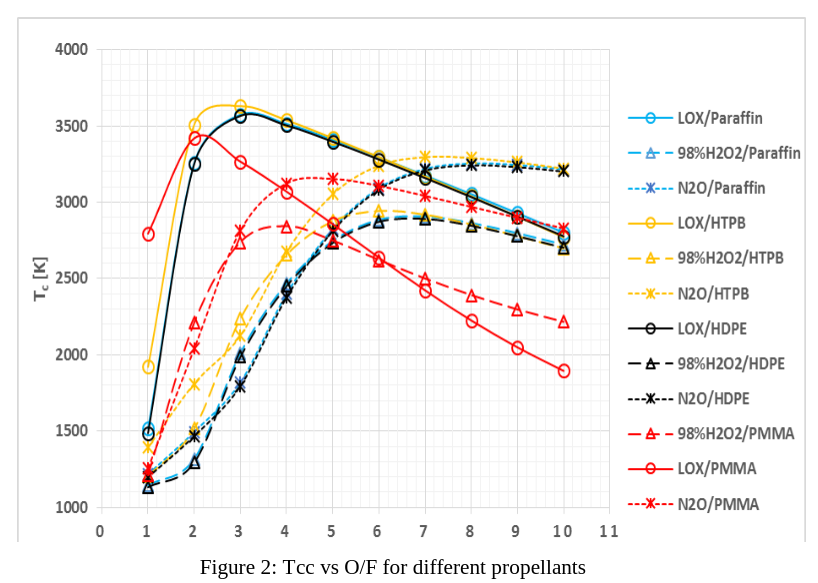

In [ ]:
# optimisation stuff


In [ ]:
#optimisedoxidiser total available mass
# max impulse

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.interpolate import interp1d

# Constants (unchanged)
R, k, M, p1, p2 = 8.314, 1.33, 0.02897, 10e5, 1e5
a, n = 15.5e-2 / 1000, 0.5
d = 900  # Paraffin density

# N2O/Paraffin temperature vs O/F data (extracted from Figure 2)
OF_data = np.array([0.2, 1.0,  2.0,  3.0,  4.0 ,  6.0,  7.0,  8.0,  9.0,  10.0])
T_data = np.array([1000, 1210, 1500, 1800, 2400, 3100, 3200, 3260, 3250, 3200])  # Kelvin

# Create interpolation function
temp_interpolator = interp1d(OF_data, T_data, kind='cubic',
                             bounds_error=False, fill_value=(T_data[0], T_data[-1]))

def get_temperature_from_OF(OF_ratio):
    return float(temp_interpolator(OF_ratio))

def simulate_and_plot(r1_init, r2_val, l_val, mdot_ox, mox_available):
    r1 = r1_init
    r2 = r2_val
    l = l_val
    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0

    # Storage arrays
    t, F, r, OF_ratio, dr_values, r_dot_values, T_values = [], [], [], [], [], [], []

    # Time loop - run while there's still fuel port and oxidiser left
    while r1 <= r2 and mox <= mox_available:
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n
        r_dot = a * G_ox**n
        mdot_f = 2 * pi * l * d * r1 * dr / dt

        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)

        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        t.append(t_current)
        F.append(thrust)
        r.append(r1)
        OF_ratio.append(OF)
        dr_values.append(dr)
        r_dot_values.append(r_dot)
        T_values.append(T1)
        mox += mdot_ox * dt
        mfuel += mdot_f * dt

        r1 += dr
        t_current += dt

    m_propellant = mox + mfuel
    g = 9.81
    final_thrust = F[-1] if F else 0
    tw_ratio = final_thrust / (m_propellant * g) if m_propellant > 0 else 0
    # Compute total impulse
    total_impulse = sum(F) * dt if F else 0

    print(f"Total oxidiser consumed: {mox:.3f} kg")
    print(f"Total fuel consumed: {mfuel:.3f} kg")
    print(f"Total propellant mass: {m_propellant:.3f} kg")
    print(f"Final O/F ratio: {OF_ratio[-1]:.2f}" if OF_ratio else "No O/F data")
    print(f"Final combustion temperature: {T_values[-1]:.0f} K" if T_values else "No temp data")
    print(f"Final Thrust: {final_thrust:.2f} N")
    print(f"Total Impulse: {total_impulse:.2f} Ns")
    print(f"T/W Ratio: {tw_ratio:.2f}")

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    plots = [
        ("Thrust (N)", F),
        ("Radius (m)", r),
        ("OF Ratio", OF_ratio),
        ("Temperature (K)", T_values),
        ("dr (m)", dr_values),
        ("dr/dt (m/s)", r_dot_values)
    ]

    for ax, (label, data) in zip(axes.flat, plots):
        ax.plot(t, data, linewidth=2)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

def evaluate_case(r1_init, r2_val, l_val, mdot_ox, mox_available):
    r1 = r1_init
    r2 = r2_val
    l = l_val
    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0

    F = []
    thrust_below_limit = False

    while r1 <= r2 and mox <= mox_available:
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n
        mdot_f = 2 * pi * l * d * r1 * dr / dt

        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)
        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        if thrust < 8:
            thrust_below_limit = True
            break

        F.append(thrust)
        mox += mdot_ox * dt
        mfuel += mdot_f * dt
        r1 += dr
        t_current += dt

    if thrust_below_limit or len(F) == 0:
        return -1  # Infeasible

    impulse = sum(F) * dt
    return impulse
def optimise_impulse():
    best_impulse = -1
    best_params = None

    r1_vals = np.linspace(0.002, 0.009, 10)
    r2_vals = np.linspace(0.01, 0.01, 1)
    l_vals = np.linspace(0.03, 0.08, 10)
    mdot_ox_vals = np.linspace(0.005, 0.01, 10)
    mox_vals = np.linspace(0.002, 0.01, 10)

    total_cases = len(r1_vals) * len(r2_vals) * len(l_vals) * len(mdot_ox_vals) * len(mox_vals)
    case_num = 0

    for r1 in r1_vals:
        for r2 in r2_vals:
            for l in l_vals:
                for mdot_ox in mdot_ox_vals:
                    for mox_total in mox_vals:
                        case_num += 1
                        impulse = evaluate_case(r1, r2, l, mdot_ox, mox_total)
                        if impulse > best_impulse:
                            best_impulse = impulse
                            best_params = (r1, r2, l, mdot_ox, mox_total)
                        print(f"[{case_num}/{total_cases}] Impulse: {impulse:.2f} Ns", end='\r')

    print("\n\nBest Parameters:")
    print(f"  r1 = {best_params[0]:.4f} m")
    print(f"  r2 = {best_params[1]:.4f} m")
    print(f"  l  = {best_params[2]:.4f} m")
    print(f"  mdot_ox = {best_params[3]:.4f} kg/s")
    print(f"  mox_total = {best_params[4]:.4f} kg")
    print(f"  Maximum Impulse = {best_impulse:.2f} Ns")

    # Optionally, simulate the best configuration
    simulate_and_plot(*best_params)



# Sliders
r1_slider = widgets.FloatSlider(value=0.005, min=0.001, max=0.025, step=0.001,
                                description='r1 (m)', readout_format='.3f')
r2_slider = widgets.FloatSlider(value=0.01, min=0.001, max=0.05, step=0.001,
                                description='r2 (m)', readout_format='.3f')
l_slider = widgets.FloatSlider(value=0.04, min=0.01, max=0.3, step=0.001,
                               description='Length (m)', readout_format='.3f')
mdot_ox_slider = widgets.FloatSlider(value=0.008, min=0.0001, max=1.0, step=0.001,
                                     description='m_dot_ox (kg/s)', readout_format='.3f')
mox_total_slider = widgets.FloatSlider(value=0.008, min=0.001, max=5.0, step=0.001,
                                       description='Ox Mass (kg)', readout_format='.2f')

ui = widgets.VBox([r1_slider, r2_slider, l_slider, mdot_ox_slider, mox_total_slider])
out = widgets.Output()

def update_plot(change=None):
    with out:
        clear_output(wait=True)
        simulate_and_plot(
            r1_slider.value,
            r2_slider.value,
            l_slider.value,
            mdot_ox_slider.value,
            mox_total_slider.value
        )

# Attach callbacks
for slider in [r1_slider, r2_slider, l_slider, mdot_ox_slider, mox_total_slider]:
    slider.observe(update_plot, names='value')

# Initial display
display(ui, out)


Output()

[6000/6000] Burn Time: 1.000 s

✅ Best Burn Time Found:
  r1       = 0.0020 m
  l        = 0.0200 m
  mdot_ox  = 0.00407 kg/s
  Burn Time = 1.967 s

Simulating with best parameters...
Total oxidiser consumed: 0.008 kg
Total fuel consumed: 0.001 kg
Total propellant mass: 0.009 kg
Final O/F ratio: 6.45
Final combustion temperature: 3155 K
Final Thrust: 8.38 N
Total Impulse: 16.48 Ns
T/W Ratio: 92.36


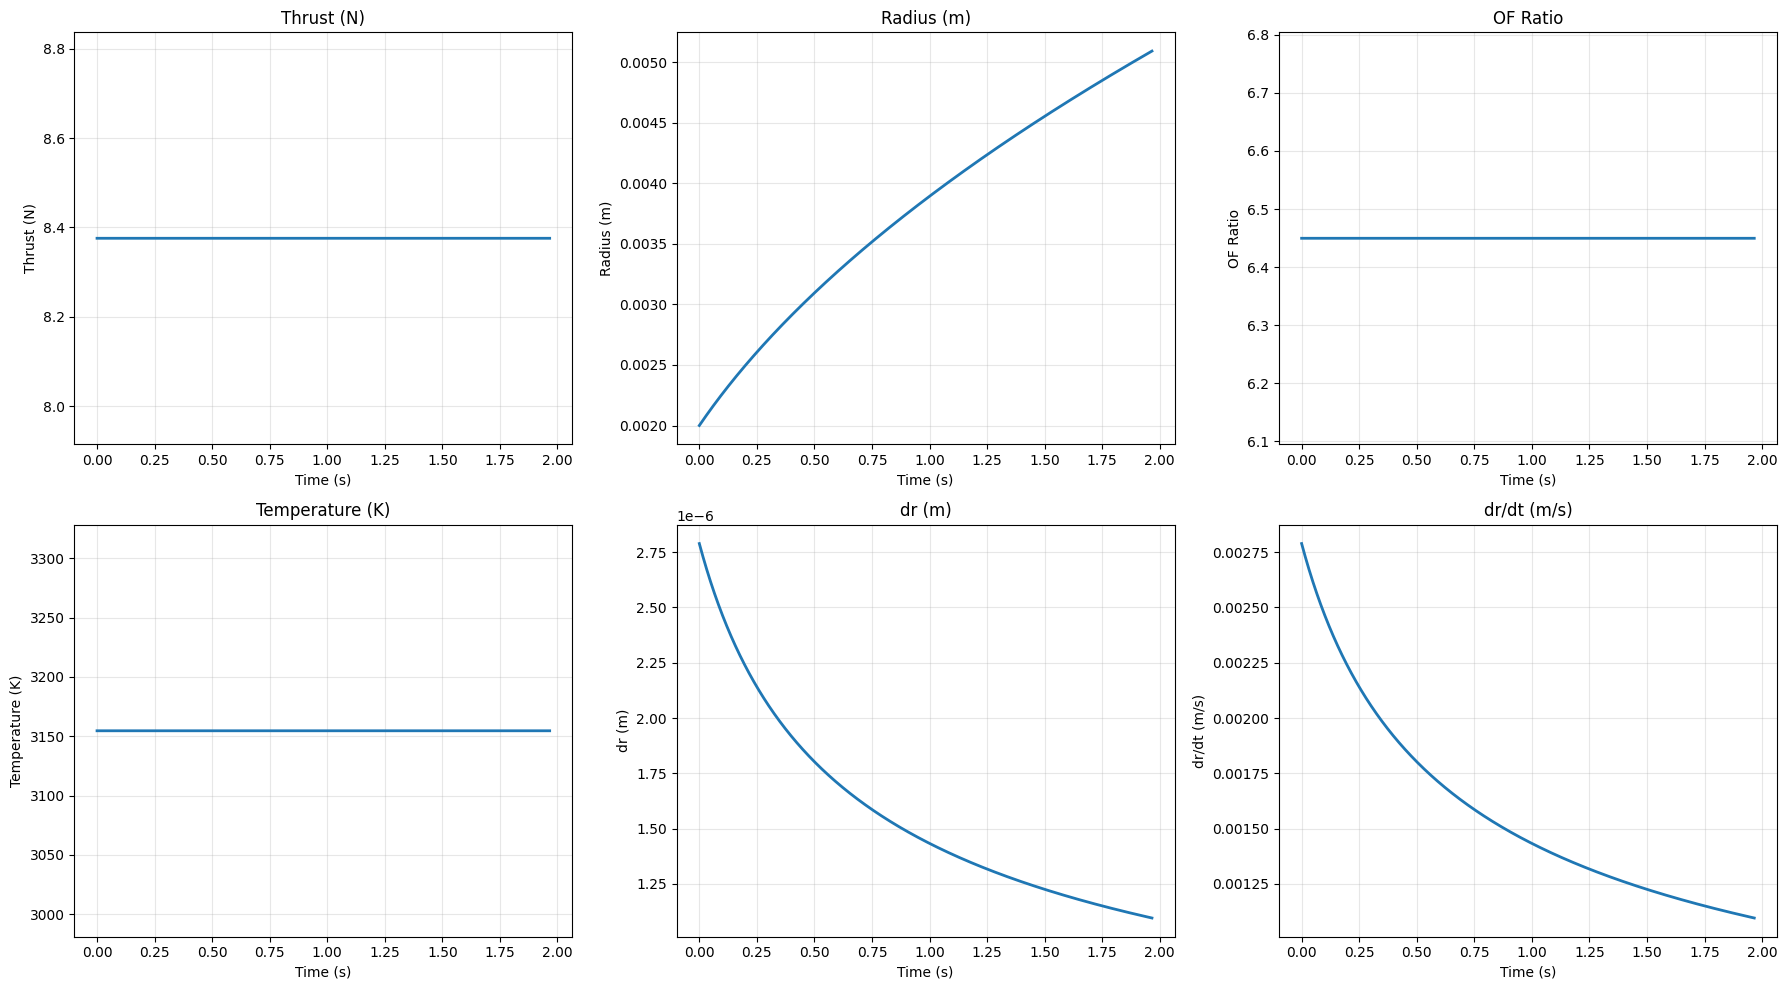

In [ ]:
def get_temperature_from_OF(OF_ratio):
    return float(temp_interpolator(OF_ratio))

def evaluate_burn_time(r1_init, l_val, mdot_ox):
    r1 = r1_init
    r2 = 0.01  # fixed
    l = l_val
    dt = 0.001
    mox_available = 0.008  # fixed
    t_current, mox, mfuel = 0.0, 0.0, 0.0

    while r1 <= r2 and mox <= mox_available:
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n
        mdot_f = 2 * pi * l * d * r1 * dr / dt

        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)

        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        if thrust < 8:
            return -1  # Not acceptable

        r1 += dr
        mox += mdot_ox * dt
        mfuel += mdot_f * dt
        t_current += dt

    return t_current

def optimise_burn_time():
    best_time = -1
    best_params = None

    r1_vals = np.linspace(0.002, 0.009, 10)
    l_vals = np.linspace(0.02, 0.1, 20)
    mdot_ox_vals = np.linspace(0.002, 0.008, 30)

    total = len(r1_vals) * len(l_vals) * len(mdot_ox_vals)
    count = 0

    for r1 in r1_vals:
        for l in l_vals:
            for mdot_ox in mdot_ox_vals:
                burn_time = evaluate_burn_time(r1, l, mdot_ox)
                count += 1
                if burn_time > best_time:
                    best_time = burn_time
                    best_params = (r1, l, mdot_ox)
                print(f"[{count}/{total}] Burn Time: {burn_time:.3f} s", end='\r')

    print("\n\n✅ Best Burn Time Found:")
    print(f"  r1       = {best_params[0]:.4f} m")
    print(f"  l        = {best_params[1]:.4f} m")
    print(f"  mdot_ox  = {best_params[2]:.5f} kg/s")
    print(f"  Burn Time = {best_time:.3f} s")

    print("\nSimulating with best parameters...")
    simulate_and_plot(best_params[0], 0.01, best_params[1], best_params[2], 0.008)

optimise_burn_time()


[10000/10000] Impulse: 17.90 Ns

Best Parameters:
  r1 = 0.0020 m
  r2 = 0.0100 m
  l  = 0.0300 m
  mdot_ox = 0.0078 kg/s
  mox_total = 0.0100 kg
  Maximum Impulse = 20.61 Ns
Total oxidiser consumed: 0.010 kg
Total fuel consumed: 0.002 kg
Total propellant mass: 0.012 kg
Final O/F ratio: 5.94
Final combustion temperature: 3091 K
Final Thrust: 16.03 N
Total Impulse: 20.61 Ns
T/W Ratio: 139.84


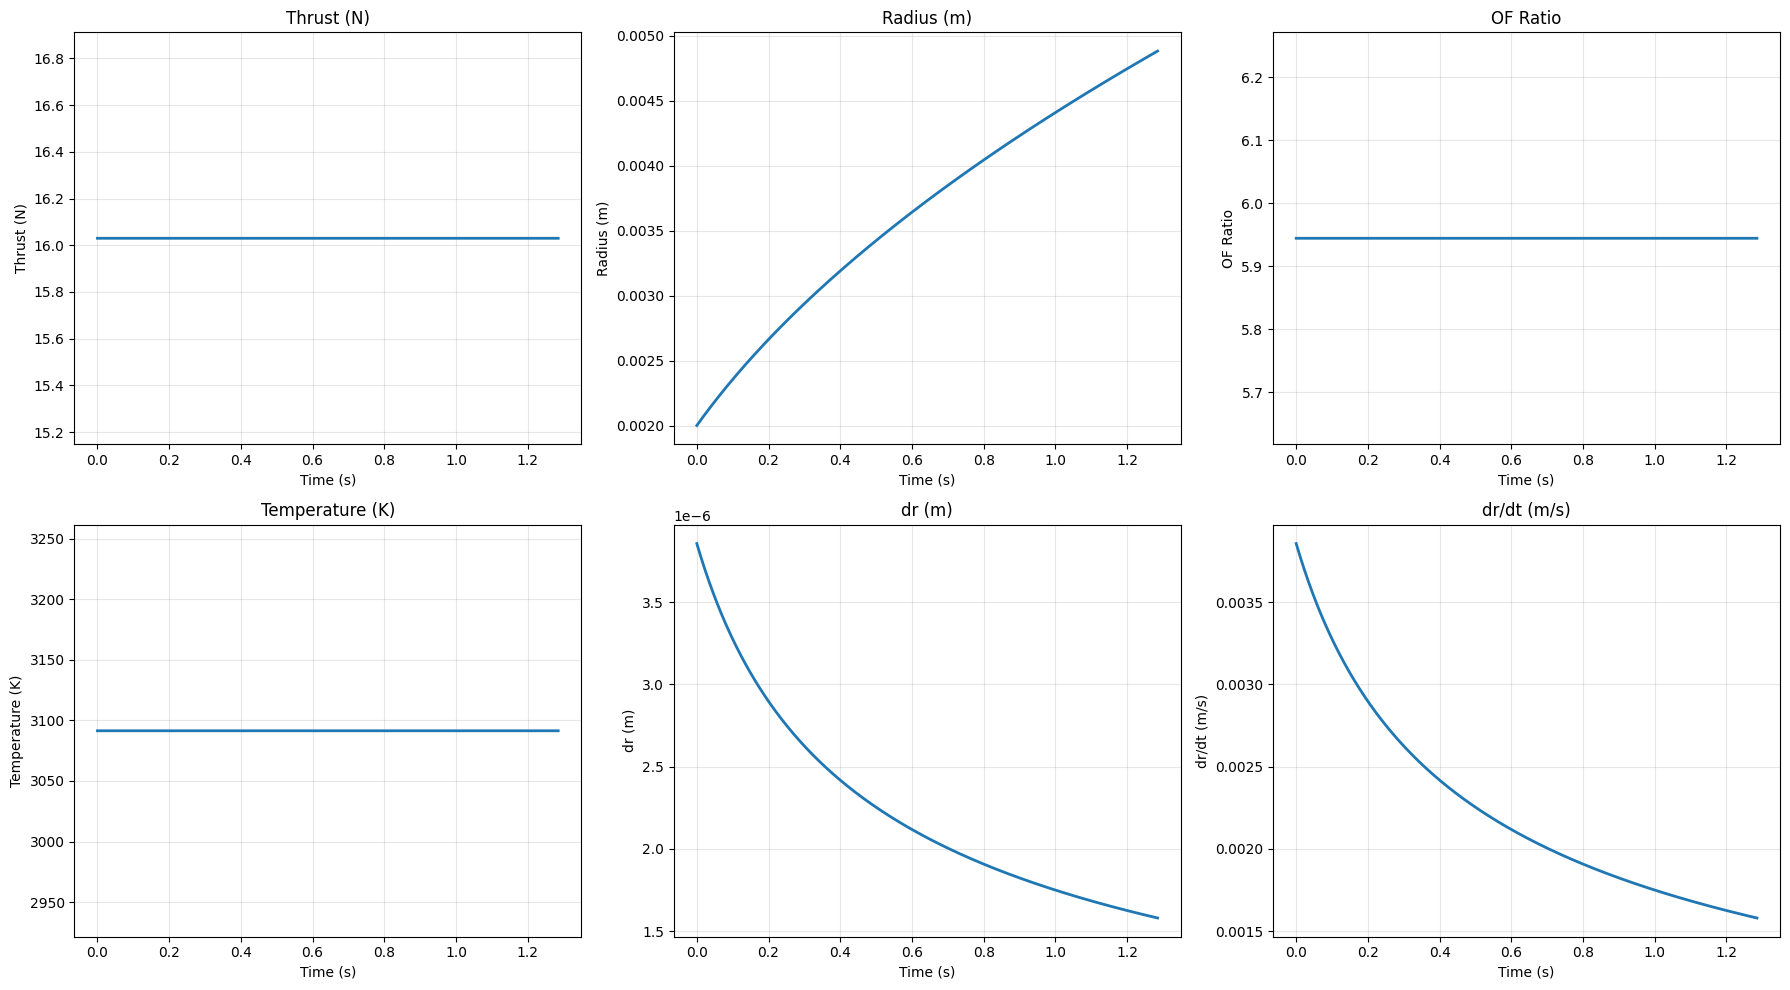

In [ ]:
optimise_impulse()

[1000/1000] Impulse: 14.33 Ns

Best Parameters:
  - r1 = 0.0020 m
  - r2 = 0.0100 m
  - l  = 0.0300 m
  - mdot_ox = 0.0083 kg/s
  - mox_total = 0.0080 kg
  - Maximum Impulse = 16.50 Ns
* Total oxidiser consumed: 0.008 kg
* Total fuel consumed: 0.001 kg
* Total propellant mass: 0.009 kg
* Final O/F ratio: 6.15
* Final combustion temperature: 3121 K
* Final Thrust: 17.17 N
* Total Impulse: 16.50 Ns
* T/W Ratio: 188.04

In [ ]:
import numpy as np
from math import sqrt, pi
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Constants
R, k, M, p1, p2 = 8.314, 1.33, 0.02897, 10e5, 1e5
a, n = 15.5e-2 / 1000, 0.5
d = 900  # Fuel density (kg/m³)
t_target = 10.0     # Target burn time in seconds
F_target = 100.0    # Target thrust in Newtons
max_oxidiser = 0.64  # Max oxidiser allowed (kg)

# O/F vs Temperature data for N2O/Paraffin
OF_data = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0])
T_data = np.array([1000, 1200, 1500, 2400, 2800, 3100, 3200, 3200, 3200, 3200, 3200, 3200])
temp_interpolator = interp1d(OF_data, T_data, kind='cubic', bounds_error=False, fill_value=(T_data[0], T_data[-1]))

def get_T(OF):
    return float(temp_interpolator(OF))

def simulate(r1, r2, l, mdot_ox):
    dt = 0.001
    t, mox, mf = 0.0, 0.0, 0.0
    r = r1
    F_arr = []

    while r <= r2:
        G_ox = mdot_ox / (pi * r**2)
        dr = dt * a * G_ox**n
        mdot_f = 2 * pi * l * d * r * dr / dt
        OF = mdot_ox / mdot_f if mdot_f > 0 else 10
        T1 = get_T(OF)
        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        mox += mdot_ox * dt
        mf += mdot_f * dt
        F_arr.append(thrust)

        r += dr
        t += dt

        if t > 30:  # Safety limit
            break

    return {
        "burn_time": t,
        "thrust_mean": np.mean(F_arr),
        "m_ox": mox,
        "m_f": mf,
        "thrust_profile": F_arr
    }

# Objective: Minimise total propellant mass
def objective(x):
    r1, r2, l, mdot_ox = x
    sim = simulate(r1, r2, l, mdot_ox)
    return sim["m_ox"] + sim["m_f"]

# Constraints
def constraint_burn_time(x):
    return simulate(*x)["burn_time"] - t_target

def constraint_thrust(x):
    return simulate(*x)["thrust_mean"] - F_target

def constraint_oxidiser(x):
    return max_oxidiser - simulate(*x)["m_ox"]

# Bounds: r1, r2, l, mdot_ox
bounds = [
    (0.002, 0.02),   # r1
    (0.01, 0.04),    # r2
    (0.05, 0.3),     # l
    (0.01, 0.2)      # mdot_ox
]

constraints = [
    {'type': 'eq', 'fun': constraint_burn_time},
    {'type': 'eq', 'fun': constraint_thrust},
    {'type': 'ineq', 'fun': constraint_oxidiser}
]

# Initial guess
x0 = [0.01, 0.025, 0.1, 0.05]

#result = minimize(objective, x0, bounds=bounds, constraints=constraints, method='SLSQP', options={'disp': True})
# Relaxing tolerance for convergence
result = minimize(objective, x0, bounds=bounds, constraints=constraints, method='SLSQP', options={'disp': True, 'ftol': 1e-2, 'maxiter': 500})


if result.success:
    r1_opt, r2_opt, l_opt, mdot_ox_opt = result.x
    sim = simulate(r1_opt, r2_opt, l_opt, mdot_ox_opt)
    print("\n✅ Optimisation Successful!")
    print(f"r1:         {r1_opt:.4f} m")
    print(f"r2:         {r2_opt:.4f} m")
    print(f"Length:     {l_opt:.4f} m")
    print(f"m_dot_ox:   {mdot_ox_opt:.4f} kg/s")
    print(f"Burn Time:  {sim['burn_time']:.2f} s")
    print(f"Thrust Avg: {sim['thrust_mean']:.2f} N")
    print(f"m_ox:       {sim['m_ox']:.4f} kg")
    print(f"m_f:        {sim['m_f']:.4f} kg")
    print(f"Total Mass: {sim['m_ox'] + sim['m_f']:.4f} kg")
else:
    print("❌ Optimisation failed:", result.message)


Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 0.8196383387440382
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
❌ Optimisation failed: Singular matrix C in LSQ subproblem


✅ Optimisation successful!

Optimal r1:       0.0100 m
Optimal r2:       0.0250 m
Optimal length:   0.0500 m
Optimal mdot_ox:  0.0266 kg/s

➡️ Simulating with optimal parameters...

Total oxidiser consumed: 0.266 kg
Total fuel consumed: 0.040 kg
Total propellant mass: 0.307 kg
Final O/F ratio: 6.60
Final combustion temperature: 3168 K
Final Thrust: 54.74 N
T/W Ratio: 18.20


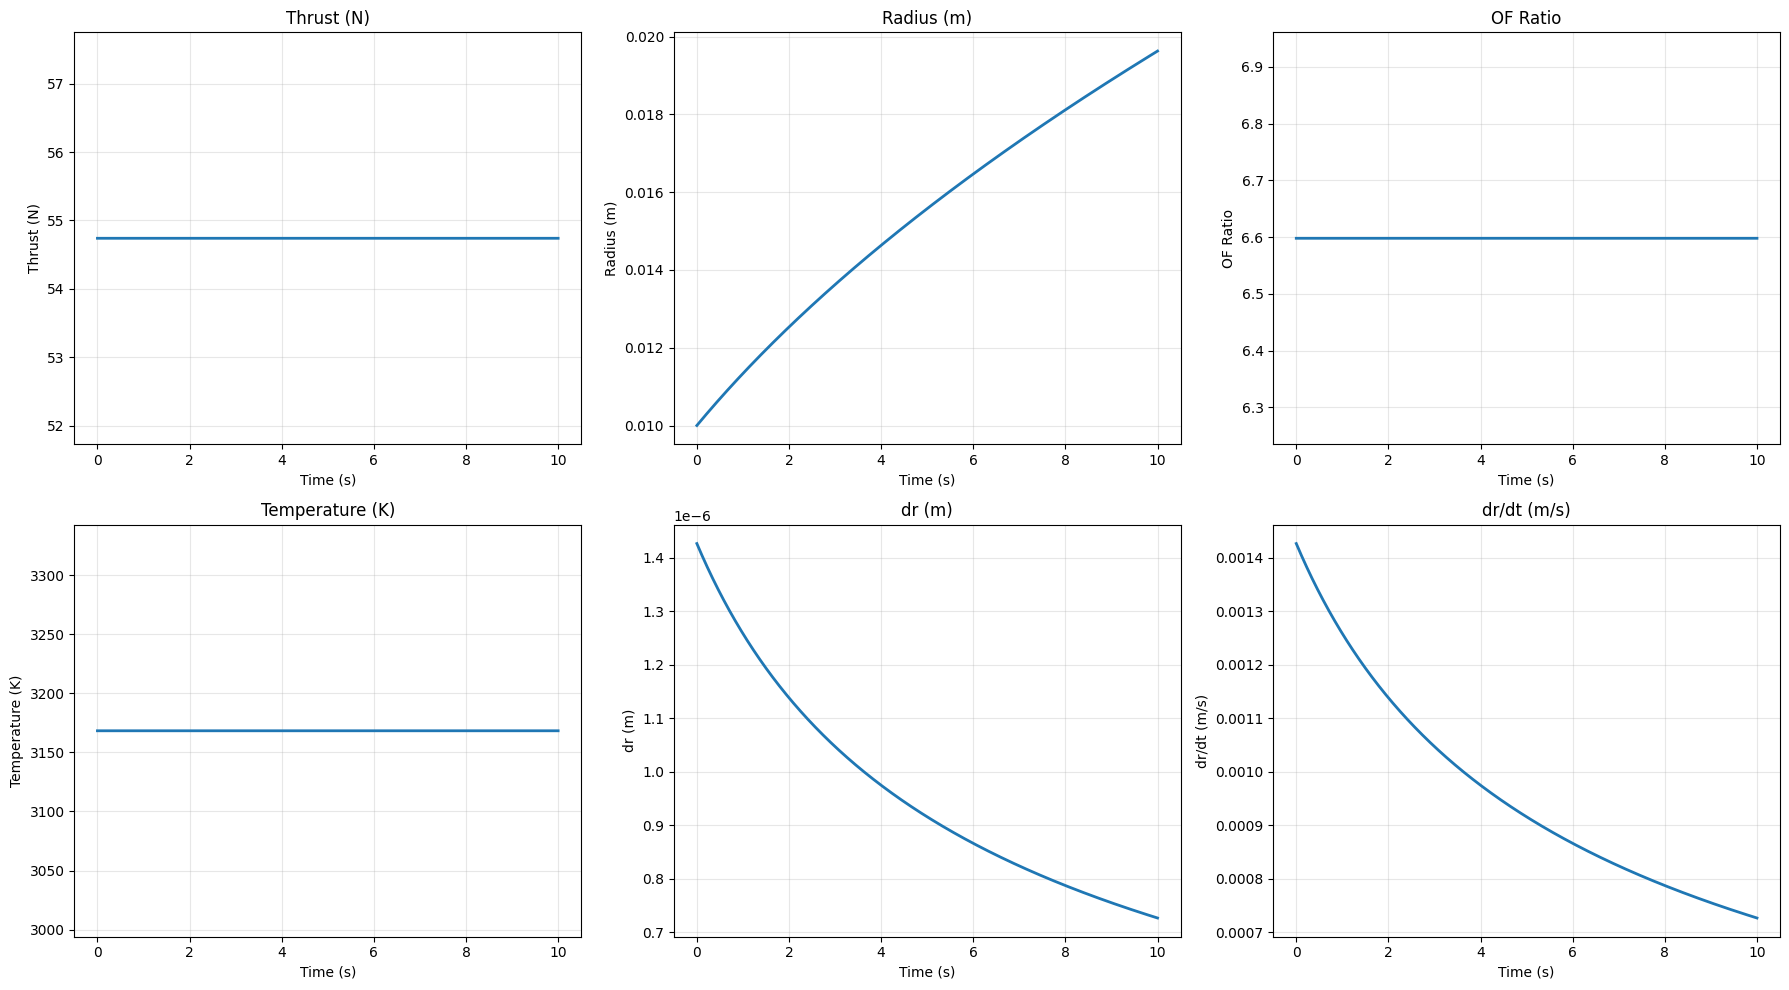

In [ ]:
# MAIN CODE WITH OPTIMISATION

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.interpolate import interp1d
from scipy.optimize import minimize

# Constants
R, k, M, p1, p2 = 8.314, 1.33, 0.02897, 10e5, 1e5
a, n = 15.5e-2 / 1000, 0.5
d = 900  # Paraffin density

# Temperature vs O/F (edited)
OF_data = np.array([0.2, 1.0, 2.0, 3.0, 4.0 , 6.0, 7.0, 8.0, 9.0, 10.0])
T_data = np.array([1000, 1210, 1500, 1800, 2400, 3100, 3200, 3260, 3250, 3200])

temp_interpolator = interp1d(OF_data, T_data, kind='cubic',
                             bounds_error=False, fill_value=(T_data[0], T_data[-1]))

def get_temperature_from_OF(OF_ratio):
    return float(temp_interpolator(OF_ratio))

def simulate_and_plot(r1_init, r2_val, l_val, mdot_ox):
    r1 = r1_init
    r2 = r2_val
    l = l_val
    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0

    # Storage arrays
    t, F, r, OF_ratio, dr_values, r_dot_values, T_values = [], [], [], [], [], [], []

    while r1 <= r2:
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n
        r_dot = a * G_ox**n
        mdot_f = 2 * pi * l * d * r1 * dr / dt

        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)

        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        # Store
        t.append(t_current)
        F.append(thrust)
        r.append(r1)
        OF_ratio.append(OF)
        dr_values.append(dr)
        r_dot_values.append(r_dot)
        T_values.append(T1)
        mox += mdot_ox * dt
        mfuel += mdot_f * dt

        r1 += dr
        t_current += dt
        if t_current > 10:  # safety cutoff
            break

    m_propellant = mox + mfuel
    g = 9.81
    final_thrust = F[-1]
    tw_ratio = final_thrust / (m_propellant * g) if m_propellant > 0 else 0

    print(f"Total oxidiser consumed: {mox:.3f} kg")
    print(f"Total fuel consumed: {mfuel:.3f} kg")
    print(f"Total propellant mass: {m_propellant:.3f} kg")
    print(f"Final O/F ratio: {OF_ratio[-1]:.2f}")
    print(f"Final combustion temperature: {T_values[-1]:.0f} K")
    print(f"Final Thrust: {final_thrust:.2f} N")
    print(f"T/W Ratio: {tw_ratio:.2f}")

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    plots = [
        ("Thrust (N)", F),
        ("Radius (m)", r),
        ("OF Ratio", OF_ratio),
        ("Temperature (K)", T_values),
        ("dr (m)", dr_values),
        ("dr/dt (m/s)", r_dot_values)
    ]
    for ax, (label, data) in zip(axes.flat, plots):
        ax.plot(t, data, linewidth=2)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

# ------------------- OPTIMISATION FUNCTION -------------------

def objective(x):
    r1, r2, l, mdot_ox = x
    if r1 >= r2 or r1 <= 0 or r2 <= 0 or l <= 0 or mdot_ox <= 0:
        return 1e6

    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0
    T_values = []
    r1_local = r1

    while r1_local <= r2:
        G_ox = mdot_ox / (pi * r1_local**2)
        dr = dt * a * G_ox**n
        mdot_f = 2 * pi * l * d * r1_local * dr / dt
        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)
        T_values.append(T1)
        mox += mdot_ox * dt
        mfuel += mdot_f * dt
        r1_local += dr
        t_current += dt
        if t_current > 10:
            break

    if not T_values:
        return 1e5

    max_temp = max(T_values)
    m_propellant = mox + mfuel

    # Objective: minimize mass, reward higher T
    return m_propellant - 0.001 * max_temp

# ------------------- RUN OPTIMISATION -------------------

bounds = [
    (0.001, 0.02),   # r1
    (0.015, 0.05),   # r2
    (0.05, 0.3),     # length
    (0.001, 0.5)     # mdot_ox
]

x0 = [0.01, 0.025, 0.1, 0.05]

result = minimize(objective, x0, bounds=bounds, method='SLSQP')

if result.success:
    r1_opt, r2_opt, l_opt, mdot_ox_opt = result.x
    print("✅ Optimisation successful!\n")
    print(f"Optimal r1:       {r1_opt:.4f} m")
    print(f"Optimal r2:       {r2_opt:.4f} m")
    print(f"Optimal length:   {l_opt:.4f} m")
    print(f"Optimal mdot_ox:  {mdot_ox_opt:.4f} kg/s\n")
    print("➡️ Simulating with optimal parameters...\n")
    simulate_and_plot(r1_opt, r2_opt, l_opt, mdot_ox_opt)
else:
    print("❌ Optimisation failed:", result.message)


Output()


✅ Optimisation successful!
Best parameters:
r1: 0.0100 m
r2: 0.0250 m
l : 0.0500 m
mdot_ox: 0.9995 kg/s

--- Simulating with optimal values ---

Total oxidiser consumed: 3.001 kg
Total fuel consumed: 0.074 kg
Total propellant mass: 3.075 kg
Final O/F ratio: 40.43
Final combustion temperature: 3200 K
Final Thrust: 1838.43 N
T/W Ratio: 60.95


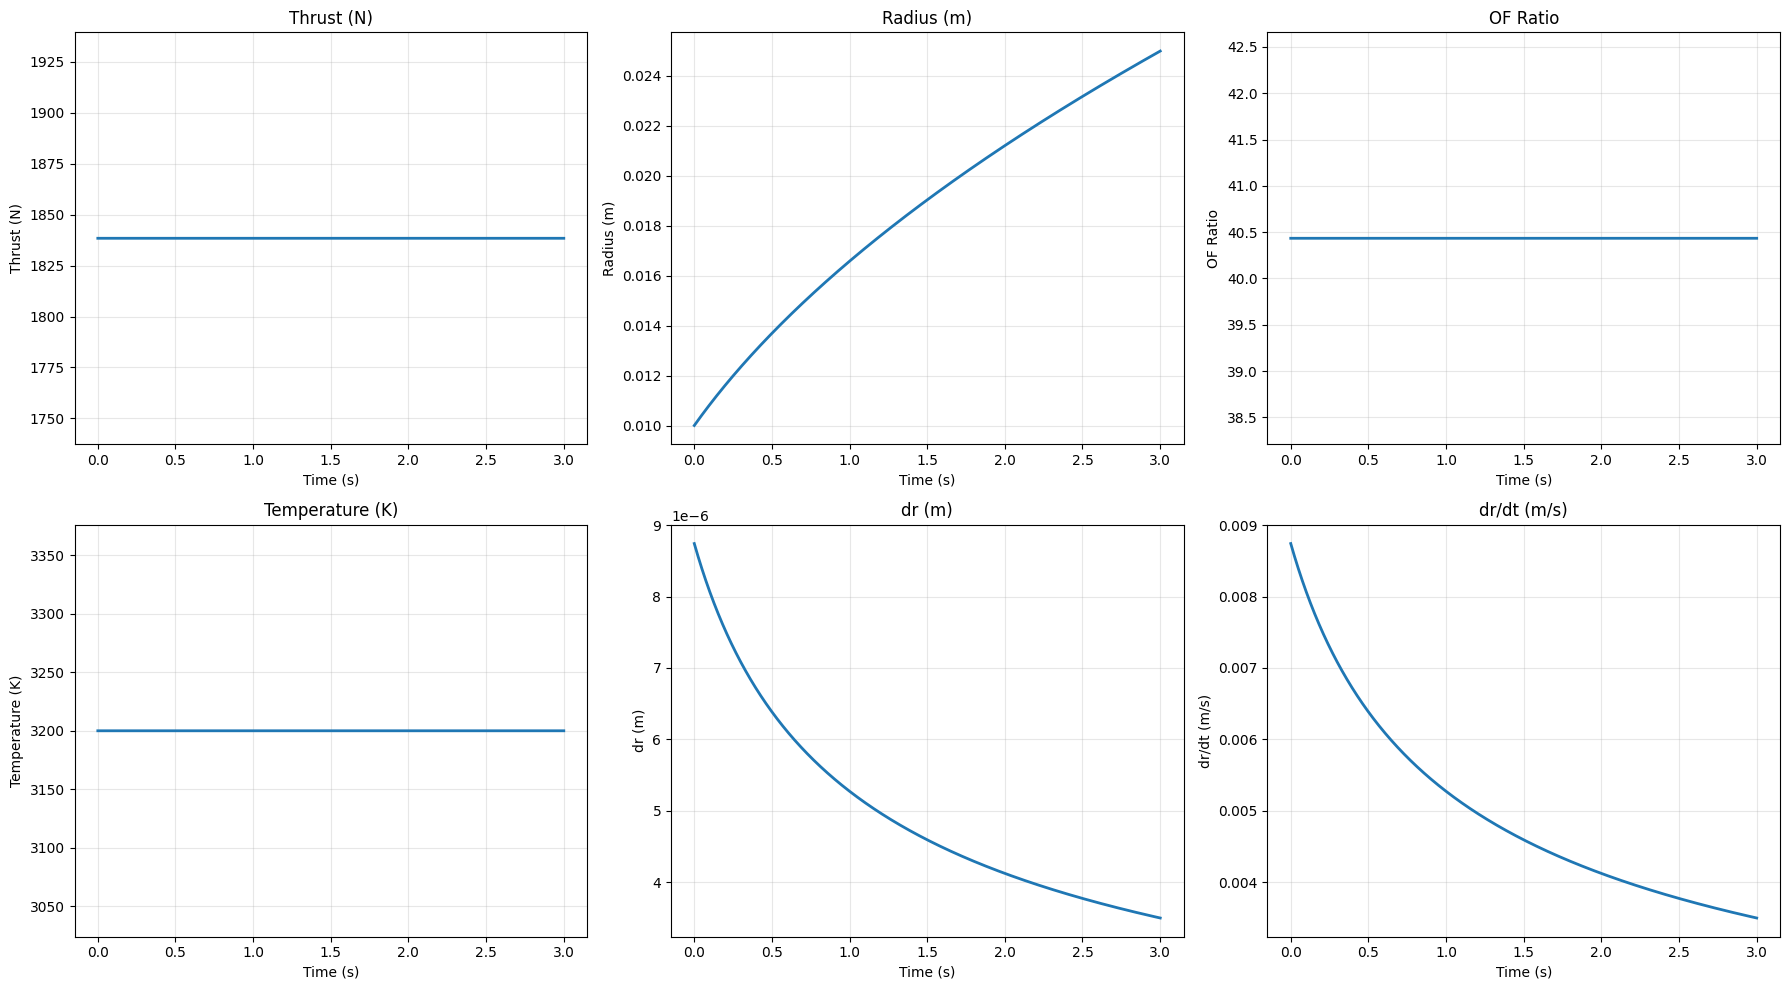

In [ ]:
# MAIN CODE — HYBRID ROCKET SIM + OPTIMISATION

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.interpolate import interp1d
from scipy.optimize import minimize

# --- Constants ---
R, k, M, p1, p2 = 8.314, 1.33, 0.02897, 10e5, 1e5
a, n = 15.5e-2 / 1000, 0.5
d = 900  # Paraffin density
g = 9.81

# --- Temperature Data ---
OF_data = np.array([0.2, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0])
T_data = np.array([1000, 1210, 1500, 1800, 2400, 3100, 3200, 3260, 3250, 3200])

temp_interpolator = interp1d(OF_data, T_data, kind='cubic',
                             bounds_error=False, fill_value=(T_data[0], T_data[-1]))

def get_temperature_from_OF(OF_ratio):
    return float(temp_interpolator(OF_ratio))

# --- Simulation Function ---
def simulate_and_plot(r1_init, r2_val, l_val, mdot_ox):
    r1 = r1_init
    r2 = r2_val
    l = l_val
    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0

    t, F, r, OF_ratio, dr_values, r_dot_values, T_values = [], [], [], [], [], [], []

    while r1 <= r2:
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n
        r_dot = a * G_ox**n
        mdot_f = 2 * pi * l * d * r1 * dr / dt
        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)

        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        t.append(t_current)
        F.append(thrust)
        r.append(r1)
        OF_ratio.append(OF)
        dr_values.append(dr)
        r_dot_values.append(r_dot)
        T_values.append(T1)

        mox += mdot_ox * dt
        mfuel += mdot_f * dt
        r1 += dr
        t_current += dt

    m_propellant = mox + mfuel
    final_thrust = F[-1]
    tw_ratio = final_thrust / (m_propellant * g) if m_propellant > 0 else 0

    print(f"Total oxidiser consumed: {mox:.3f} kg")
    print(f"Total fuel consumed: {mfuel:.3f} kg")
    print(f"Total propellant mass: {m_propellant:.3f} kg")
    print(f"Final O/F ratio: {OF_ratio[-1]:.2f}")
    print(f"Final combustion temperature: {T_values[-1]:.0f} K")
    print(f"Final Thrust: {final_thrust:.2f} N")
    print(f"T/W Ratio: {tw_ratio:.2f}")

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    plots = [
        ("Thrust (N)", F),
        ("Radius (m)", r),
        ("OF Ratio", OF_ratio),
        ("Temperature (K)", T_values),
        ("dr (m)", dr_values),
        ("dr/dt (m/s)", r_dot_values)
    ]

    for ax, (label, data) in zip(axes.flat, plots):
        ax.plot(t, data, linewidth=2)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

# --- Interactive Sliders ---
r1_slider = widgets.FloatSlider(value=0.01, min=0.001, max=0.025, step=0.001, description='r1 (m)', readout_format='.3f')
r2_slider = widgets.FloatSlider(value=0.02, min=0.01, max=0.05, step=0.001, description='r2 (m)', readout_format='.3f')
l_slider = widgets.FloatSlider(value=0.1, min=0.05, max=0.3, step=0.01, description='Length (m)', readout_format='.3f')
mdot_ox_slider = widgets.FloatSlider(value=0.044, min=0.0001, max=1.0, step=0.001, description='m_dot_ox (kg/s)', readout_format='.3f')

ui = widgets.VBox([r1_slider, r2_slider, l_slider, mdot_ox_slider])
out = widgets.Output()

def update_plot(change=None):
    with out:
        clear_output(wait=True)
        simulate_and_plot(r1_slider.value, r2_slider.value, l_slider.value, mdot_ox_slider.value)

r1_slider.observe(update_plot, names='value')
r2_slider.observe(update_plot, names='value')
l_slider.observe(update_plot, names='value')
mdot_ox_slider.observe(update_plot, names='value')

display(ui, out)

# --- OPTIMISATION SECTION ---

def objective(x):
    r1, r2, l, mdot_ox = x
    if r1 >= r2 or r1 <= 0 or r2 <= 0 or l <= 0 or mdot_ox <= 0:
        return 1e6

    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0
    T_values, F_values = [], []
    r1_local = r1

    while r1_local <= r2:
        G_ox = mdot_ox / (pi * r1_local**2)
        dr = dt * a * G_ox**n
        mdot_f = 2 * pi * l * d * r1_local * dr / dt
        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)
        T_values.append(T1)

        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v
        F_values.append(thrust)

        mox += mdot_ox * dt
        mfuel += mdot_f * dt
        r1_local += dr
        t_current += dt
        if t_current > 10:
            break

    if not T_values or not F_values:
        return 1e5

    max_temp = max(T_values)
    max_thrust = max(F_values)
    m_propellant = mox + mfuel
    tw_ratio = max_thrust / (m_propellant * g) if m_propellant > 0 else 0

    # Weighted objective (we want to minimise this)
    return 1 * m_propellant - 0.001 * max_temp - 1 * tw_ratio

# Run optimisation
x0 = [0.01, 0.025, 0.1, 0.05]
bounds = [(0.001, 0.025), (0.01, 0.05), (0.05, 0.3), (0.001, 1.0)]
result = minimize(objective, x0, bounds=bounds, method='SLSQP')

if result.success:
    print("\n✅ Optimisation successful!")
    print("Best parameters:")
    print(f"r1: {result.x[0]:.4f} m")
    print(f"r2: {result.x[1]:.4f} m")
    print(f"l : {result.x[2]:.4f} m")
    print(f"mdot_ox: {result.x[3]:.4f} kg/s")
    print("\n--- Simulating with optimal values ---\n")
    simulate_and_plot(*result.x)
else:
    print("❌ Optimisation failed.")
    print(result.message)


Output()


✅ Optimisation successful!
Best parameters:
r1: 0.0100 m
r2: 0.0250 m
l : 0.0500 m
mdot_ox: 0.9995 kg/s

--- Simulating with optimal values ---

Total oxidiser consumed: 3.001 kg
Total fuel consumed: 0.074 kg
Total propellant mass: 3.075 kg
Final O/F ratio: 40.43
Final combustion temperature: 3200 K
Final Thrust: 1838.43 N
T/W Ratio: 60.95


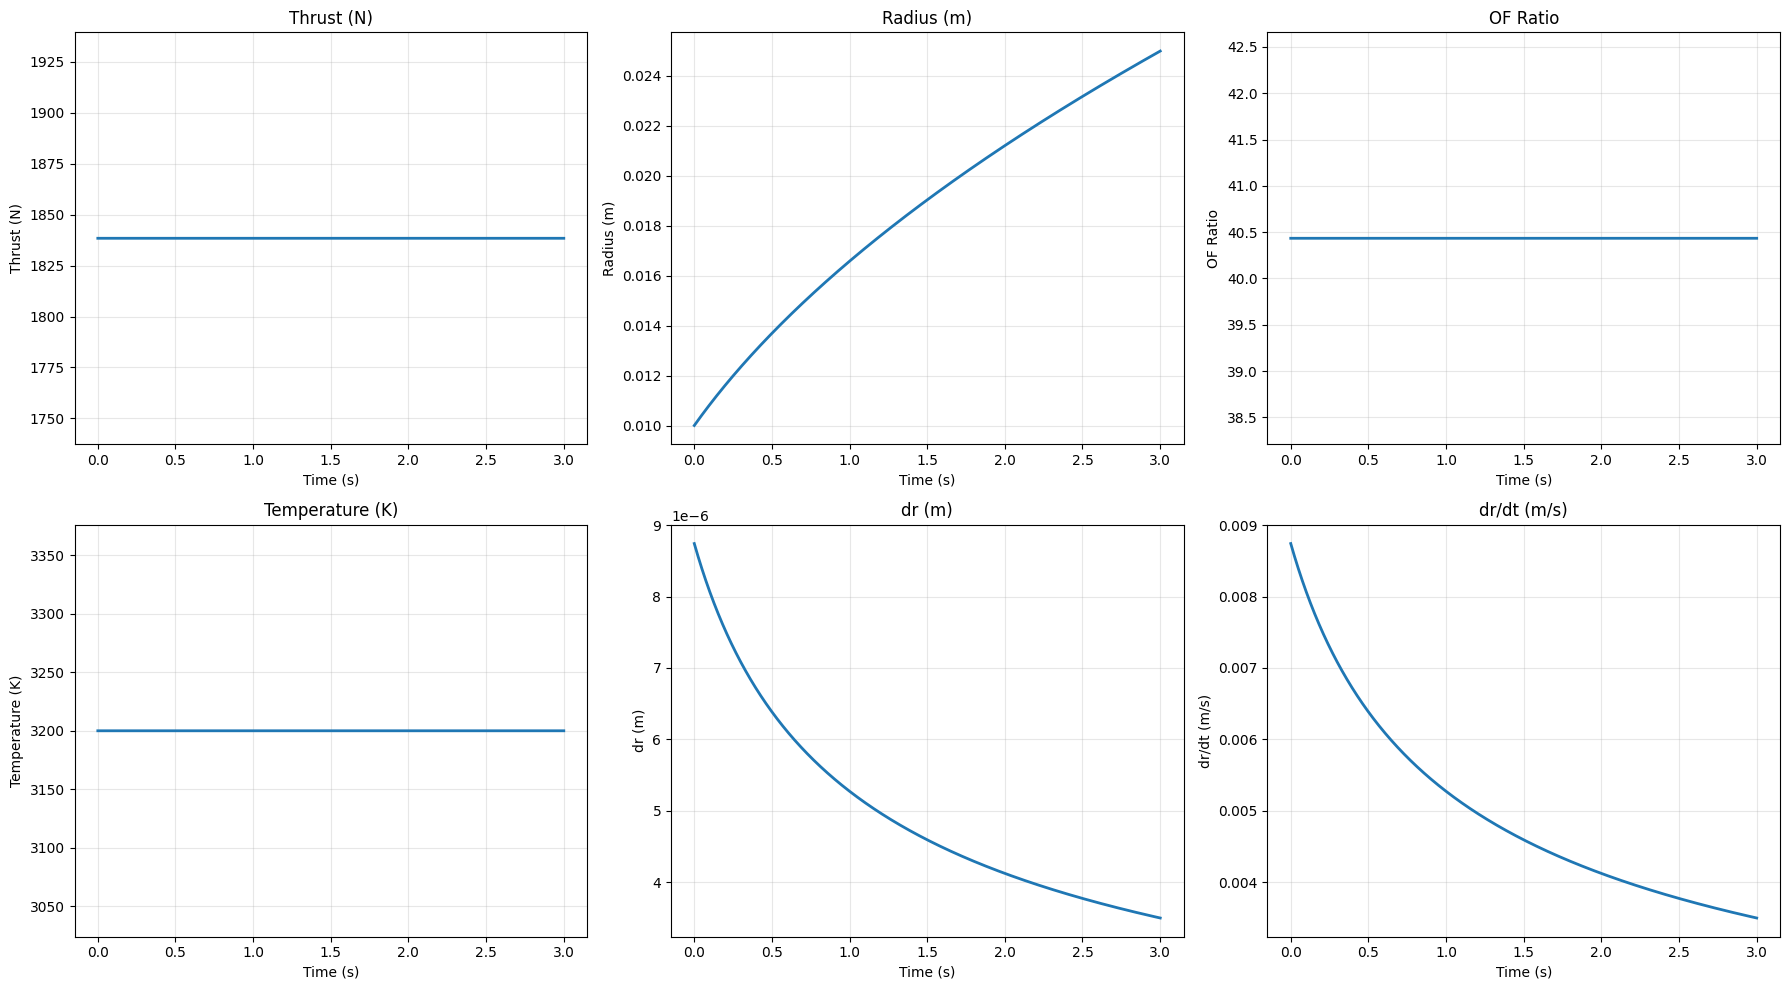

In [ ]:
# MAIN CODE — HYBRID ROCKET SIM + OPTIMISATION

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.interpolate import interp1d
from scipy.optimize import minimize

# --- Constants ---
R, k, M, p1, p2 = 8.314, 1.33, 0.02897, 10e5, 1e5
a, n = 15.5e-2 / 1000, 0.5
d = 900  # Paraffin density
g = 9.81

# --- Temperature Data ---
OF_data = np.array([0.2, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0])
T_data = np.array([1000, 1210, 1500, 1800, 2400, 3100, 3200, 3260, 3250, 3200])

temp_interpolator = interp1d(OF_data, T_data, kind='cubic',
                             bounds_error=False, fill_value=(T_data[0], T_data[-1]))

def get_temperature_from_OF(OF_ratio):
    return float(temp_interpolator(OF_ratio))

# --- Simulation Function ---
def simulate_and_plot(r1_init, r2_val, l_val, mdot_ox):
    r1 = r1_init
    r2 = r2_val
    l = l_val
    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0

    t, F, r, OF_ratio, dr_values, r_dot_values, T_values = [], [], [], [], [], [], []

    while r1 <= r2:
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n
        r_dot = a * G_ox**n
        mdot_f = 2 * pi * l * d * r1 * dr / dt
        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)

        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        t.append(t_current)
        F.append(thrust)
        r.append(r1)
        OF_ratio.append(OF)
        dr_values.append(dr)
        r_dot_values.append(r_dot)
        T_values.append(T1)

        mox += mdot_ox * dt
        mfuel += mdot_f * dt
        r1 += dr
        t_current += dt

    m_propellant = mox + mfuel
    final_thrust = F[-1]
    tw_ratio = final_thrust / (m_propellant * g) if m_propellant > 0 else 0

    print(f"Total oxidiser consumed: {mox:.3f} kg")
    print(f"Total fuel consumed: {mfuel:.3f} kg")
    print(f"Total propellant mass: {m_propellant:.3f} kg")
    print(f"Final O/F ratio: {OF_ratio[-1]:.2f}")
    print(f"Final combustion temperature: {T_values[-1]:.0f} K")
    print(f"Final Thrust: {final_thrust:.2f} N")
    print(f"T/W Ratio: {tw_ratio:.2f}")

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    plots = [
        ("Thrust (N)", F),
        ("Radius (m)", r),
        ("OF Ratio", OF_ratio),
        ("Temperature (K)", T_values),
        ("dr (m)", dr_values),
        ("dr/dt (m/s)", r_dot_values)
    ]

    for ax, (label, data) in zip(axes.flat, plots):
        ax.plot(t, data, linewidth=2)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

# --- Interactive Sliders ---
r1_slider = widgets.FloatSlider(value=0.01, min=0.001, max=0.025, step=0.001, description='r1 (m)', readout_format='.3f')
r2_slider = widgets.FloatSlider(value=0.02, min=0.01, max=0.05, step=0.001, description='r2 (m)', readout_format='.3f')
l_slider = widgets.FloatSlider(value=0.1, min=0.05, max=0.3, step=0.01, description='Length (m)', readout_format='.3f')
mdot_ox_slider = widgets.FloatSlider(value=0.044, min=0.0001, max=1.0, step=0.001, description='m_dot_ox (kg/s)', readout_format='.3f')

ui = widgets.VBox([r1_slider, r2_slider, l_slider, mdot_ox_slider])
out = widgets.Output()

def update_plot(change=None):
    with out:
        clear_output(wait=True)
        simulate_and_plot(r1_slider.value, r2_slider.value, l_slider.value, mdot_ox_slider.value)

r1_slider.observe(update_plot, names='value')
r2_slider.observe(update_plot, names='value')
l_slider.observe(update_plot, names='value')
mdot_ox_slider.observe(update_plot, names='value')

display(ui, out)

# --- OPTIMISATION SECTION ---

def objective(x):
    r1, r2, l, mdot_ox = x
    if r1 >= r2 or r1 <= 0 or r2 <= 0 or l <= 0 or mdot_ox <= 0:
        return 1e6

    dt = 0.001
    t_current, mox, mfuel = 0.0, 0.0, 0.0
    T_values, F_values = [], []
    r1_local = r1

    while r1_local <= r2:
        G_ox = mdot_ox / (pi * r1_local**2)
        dr = dt * a * G_ox**n
        mdot_f = 2 * pi * l * d * r1_local * dr / dt
        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T1 = get_temperature_from_OF(OF)
        T_values.append(T1)

        v = sqrt((2 * k / (k - 1)) * R * (T1 / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v
        F_values.append(thrust)

        mox += mdot_ox * dt
        mfuel += mdot_f * dt
        r1_local += dr
        t_current += dt
        if t_current > 10:
            break

    if not T_values or not F_values:
        return 1e5

    max_temp = max(T_values)
    max_thrust = max(F_values)
    m_propellant = mox + mfuel
    tw_ratio = max_thrust / (m_propellant * g) if m_propellant > 0 else 0

    # Weighted objective (we want to minimise this)
    return 1 * m_propellant - 0.001 * max_temp - 1 * tw_ratio

# Run optimisation
x0 = [0.01, 0.025, 0.1, 0.05]
bounds = [(0.001, 0.025), (0.01, 0.05), (0.05, 0.3), (0.001, 1.0)]
result = minimize(objective, x0, bounds=bounds, method='SLSQP')

if result.success:
    print("\n✅ Optimisation successful!")
    print("Best parameters:")
    print(f"r1: {result.x[0]:.4f} m")
    print(f"r2: {result.x[1]:.4f} m")
    print(f"l : {result.x[2]:.4f} m")
    print(f"mdot_ox: {result.x[3]:.4f} kg/s")
    print("\n--- Simulating with optimal values ---\n")
    simulate_and_plot(*result.x)
else:
    print("❌ Optimisation failed.")
    print(result.message)


In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
from math import pi, sqrt
import random
from scipy.interpolate import interp1d

# ------------------------- Constants ------------------------
R, k, M, p1, p2 = 8.314, 1.33, 0.02897, 10e5, 1e5
a, n = 15.5e-2 / 1000, 0.5
d = 900  # Paraffin density
g = 9.81

# Target constraints
target_thrust = 50    # N
target_burn_time = 2  # seconds

# ---------------------- Temp Interpolator --------------------
OF_data = np.array([0.2, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0])
T_data = np.array([1000, 1210, 1500, 1800, 2400, 3100, 3200, 3260, 3250, 3200])
temp_interpolator = interp1d(OF_data, T_data, kind='cubic', bounds_error=False,
                             fill_value=(T_data[0], T_data[-1]))

def get_temperature_from_OF(of):
    return float(temp_interpolator(of))


# ---------------- Simulation Core ----------------
def simulate_full(r1_init, r2_val, l_val, mdot_ox):
    r1 = r1_init
    dt = 0.001
    t, F, T_vals = [], [], []
    mox, mfuel = 0, 0
    t_current = 0

    while r1 <= r2_val:
        # Ensure mass flow rate does not grow too quickly
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n

        # Fuel mass flow calculation adjusted for a more realistic rate
        mdot_f = max(2 * pi * l_val * d * r1 * dr / dt, 0)  # Ensure positive fuel flow

        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T = get_temperature_from_OF(OF)
        v = sqrt((2 * k / (k - 1)) * R * (T / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        t.append(t_current)
        F.append(thrust)
        T_vals.append(T)
        mox += mdot_ox * dt
        mfuel += mdot_f * dt
        r1 += dr
        t_current += dt

    return t, F, T_vals, mox, mfuel


# ----------------- DEAP Optimisation -----------------

creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, 1.0))  # Max T, Min m, Max T/W
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# Parameters: r1, r2, l, mdot_ox
param_bounds = [(0.001, 0.03), (0.001, 0.6), (0.05, 0.3), (0.0050, 0.3)]

toolbox.register("attr_float", lambda low, high: random.uniform(low, high))
toolbox.register("individual", tools.initCycle, creator.Individual,
                 [lambda: toolbox.attr_float(l, h) for l, h in param_bounds], n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    r1, r2, l, mdot_ox = individual

    if r1 >= r2 or any([
        not (0.001 <= r1 <= 0.05),
        not (0.001 <= r2 <= 0.05),
        not (0.05 <= l <= 0.3),
        not (0.001 <= mdot_ox <= 1.0)
    ]):
        return 0, 1e6, 0  # Penalize invalid designs

    try:
        t, F, T_vals, mox, mfuel = simulate_full(r1, r2, l, mdot_ox)
        burn_time = t[-1]
        avg_thrust = np.mean(F)
        m_total = mox + mfuel
        T_peak = max(T_vals)
        TWR = F[-1] / (m_total * g) if m_total > 0 else 0

        # Constraint check
        if avg_thrust < target_thrust or burn_time < target_burn_time:
            m_total += 10  # Apply a more moderate penalty

        return T_peak, m_total, TWR

    except Exception:
        return 0, 1e6, 0

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.4)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.03, indpb=0.5)
toolbox.register("select", tools.selNSGA2)

# ----------------- Run GA -----------------

def run_optimisation(NGEN=40, POP_SIZE=40):
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("max", np.max, axis=0)

    pop, log = algorithms.eaMuPlusLambda(
        pop, toolbox, mu=POP_SIZE, lambda_=POP_SIZE,
        cxpb=0.6, mutpb=0.3, ngen=NGEN,
        stats=stats, halloffame=hof, verbose=True
    )

    best = hof[0]
    print(f"\nBest Design:\nr1 = {best[0]:.4f} m, r2 = {best[1]:.4f} m, l = {best[2]:.4f} m, mdot_ox = {best[3]:.4f} kg/s")
    print(f"Max T = {best.fitness.values[0]:.1f} K, Prop Mass = {best.fitness.values[1]:.3f} kg, T/W = {best.fitness.values[2]:.2f}")
    return best, log

# Call this to run
# best_design, logbook = run_optimisation()


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
#!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 4.4 MB/s eta 0:00:00


In [ ]:
best, logs = run_optimisation(NGEN=40, POP_SIZE=60)


gen	nevals	avg                         	max                         
0  	60    	[      0. 1000000.       0.]	[      0. 1000000.       0.]
1  	56    	[      0. 1000000.       0.]	[      0. 1000000.       0.]
2  	54    	[3.14633494e+01 9.83333355e+05 1.94455316e-01]	[1.88780096e+03 1.00000000e+06 1.16673189e+01]
3  	54    	[3.14633494e+01 9.83333355e+05 1.94455316e-01]	[1.88780096e+03 1.00000000e+06 1.16673189e+01]
4  	56    	[3.14633494e+01 9.83333355e+05 1.94455316e-01]	[1.88780096e+03 1.00000000e+06 1.16673189e+01]
5  	55    	[9.43900482e+01 9.50000064e+05 6.06245166e-01]	[1.88780096e+03 1.00000000e+06 1.30400721e+01]
6  	57    	[1.38973491e+02 9.33333446e+05 7.62442180e-01]	[2.67500656e+03 1.00000000e+06 1.30400721e+01]
7  	55    	[1.38973491e+02 9.33333446e+05 7.62442180e-01]	[2.67500656e+03 1.00000000e+06 1.30400721e+01]
8  	54    	[1.70303270e+02 9.16666819e+05 8.69551722e-01]	[2.67500656e+03 1.00000000e+06 1.30400721e+01]
9  	56    	[2.28373692e+02 8.83333614e+05 1.03118637e+00]	

In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
from math import pi, sqrt
import random
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ------------------------- Constants ------------------------
R, k, M, p1, p2 = 8.314, 1.33, 0.02897, 10e5, 1e5
a, n = 15.5e-2 / 1000, 0.5
d = 900  # Paraffin density
g = 9.81

# Target constraints
target_thrust = 50    # N
target_burn_time = 2  # seconds

# ---------------------- Temp Interpolator --------------------
OF_data = np.array([0.2, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0])
T_data = np.array([1000, 1210, 1500, 1800, 2400, 3100, 3200, 3260, 3250, 3200])
temp_interpolator = interp1d(OF_data, T_data, kind='cubic', bounds_error=False,
                             fill_value=(T_data[0], T_data[-1]))

def get_temperature_from_OF(of):
    return float(temp_interpolator(of))


# ---------------- Simulation Core ----------------
def simulate_full(r1_init, r2_val, l_val, mdot_ox):
    r1 = r1_init
    dt = 0.001
    t, F, T_vals = [], [], []
    mox, mfuel = 0, 0
    t_current = 0

    while r1 <= r2_val:
        # Ensure mass flow rate does not grow too quickly
        G_ox = mdot_ox / (pi * r1**2)
        dr = dt * a * G_ox**n

        # Fuel mass flow calculation adjusted for a more realistic rate
        mdot_f = max(2 * pi * l_val * d * r1 * dr / dt, 0)  # Ensure positive fuel flow

        OF = mdot_ox / mdot_f if mdot_f > 0 else 10.0
        T = get_temperature_from_OF(OF)
        v = sqrt((2 * k / (k - 1)) * R * (T / M) * (1 - (p2 / p1)**((k - 1) / k)))
        thrust = (mdot_ox + mdot_f) * v

        t.append(t_current)
        F.append(thrust)
        T_vals.append(T)
        mox += mdot_ox * dt
        mfuel += mdot_f * dt
        r1 += dr
        t_current += dt

    return t, F, T_vals, mox, mfuel


# ----------------- DEAP Optimisation -----------------

creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, 1.0))  # Max T, Min m, Max T/W
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# Parameters: r1, r2, l, mdot_ox
param_bounds = [(0.001, 0.03), (0.001, 0.6), (0.05, 0.3), (0.0050, 0.3)]

toolbox.register("attr_float", lambda low, high: random.uniform(low, high))
toolbox.register("individual", tools.initCycle, creator.Individual,
                 [lambda: toolbox.attr_float(l, h) for l, h in param_bounds], n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    r1, r2, l, mdot_ox = individual

    if r1 >= r2 or any([
        not (0.001 <= r1 <= 0.05),
        not (0.001 <= r2 <= 0.05),
        not (0.05 <= l <= 0.3),
        not (0.001 <= mdot_ox <= 1.0)
    ]):
        return 0, 1e6, 0  # Penalize invalid designs

    try:
        t, F, T_vals, mox, mfuel = simulate_full(r1, r2, l, mdot_ox)
        burn_time = t[-1]
        avg_thrust = np.mean(F)
        m_total = mox + mfuel
        T_peak = max(T_vals)
        TWR = F[-1] / (m_total * g) if m_total > 0 else 0

        # Constraint check
        if avg_thrust < target_thrust or burn_time < target_burn_time:
            m_total += 10  # Apply a more moderate penalty

        return T_peak, m_total, TWR

    except Exception:
        return 0, 1e6, 0

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.4)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.03, indpb=0.5)
toolbox.register("select", tools.selNSGA2)

# ----------------- Run GA -----------------

def run_optimisation(NGEN=40, POP_SIZE=40):
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("max", np.max, axis=0)

    pop, log = algorithms.eaMuPlusLambda(
        pop, toolbox, mu=POP_SIZE, lambda_=POP_SIZE,
        cxpb=0.6, mutpb=0.3, ngen=NGEN,
        stats=stats, halloffame=hof, verbose=True
    )

    best = hof[0]
    print(f"\nBest Design:\nr1 = {best[0]:.4f} m, r2 = {best[1]:.4f} m, l = {best[2]:.4f} m, mdot_ox = {best[3]:.4f} kg/s")
    print(f"Max T = {best.fitness.values[0]:.1f} K, Prop Mass = {best.fitness.values[1]:.3f} kg, T/W = {best.fitness.values[2]:.2f}")

    # Collect all the fitness values from the population for Pareto front
    pareto_front = np.array([ind.fitness.values for ind in pop])
    return best, pareto_front, log

# ----------------- Plot Pareto Front -----------------

def plot_pareto_front(pareto_front):
    plt.figure(figsize=(10, 6))
    plt.scatter(pareto_front[:, 1], pareto_front[:, 0], c=pareto_front[:, 2], cmap='viridis')
    plt.colorbar(label='T/W (Thrust-to-Weight Ratio)')
    plt.xlabel('Propellant Mass (kg)')
    plt.ylabel('Max Temperature (K)')
    plt.title('Pareto Front: Max Temp vs Propellant Mass')
    plt.show()

# Call this to run the optimization and plot the Pareto Front
best_design, pareto_front, logbook = run_optimisation()
plot_pareto_front(pareto_front)



r1 = 0.0121 m, r2 = 0.0175 m, l = 0.1148 m, mdot_ox = 0.2235 kg/s
Max T = 3264.5 K, Prop Mass = 100.488 kg, T/W = 94.82

r1 = 0.0282 m, r2 = 0.0311 m, l = 0.0636 m, mdot_ox = 0.0687 kg/s
Max T = 3264.5 K, Prop Mass = 0.289 kg, T/W = 49.31


## N2O/wax injector design codes

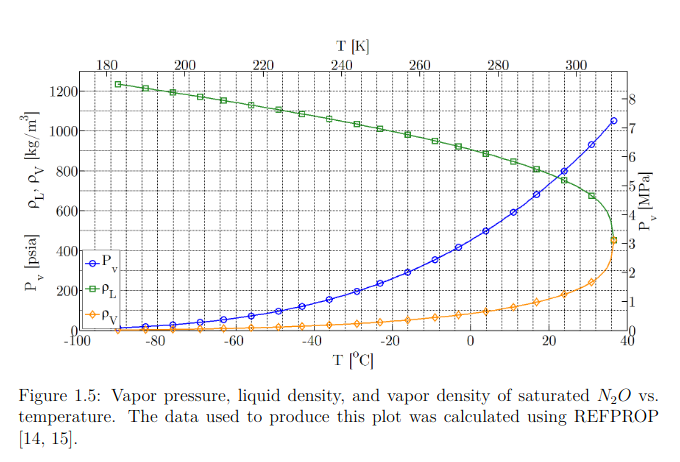

In [ ]:
# incompressible flow
pi = np.pi


### incompressible single phase flow

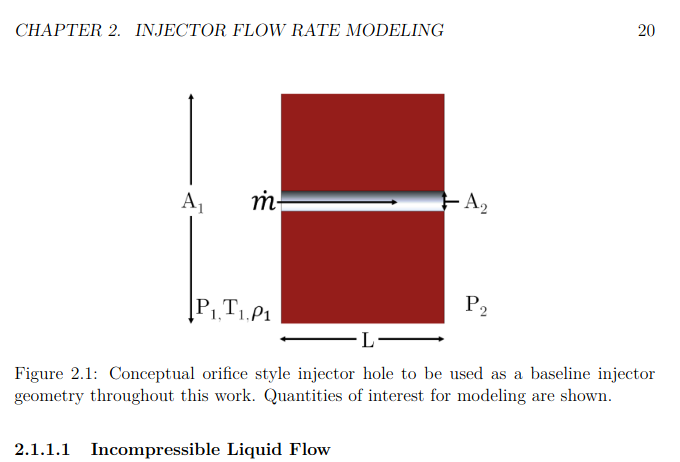

In [ ]:
d1 = 20e-3
d2 = 1.5e-3

A2 = pi*d2**2/4
A1 = pi*d1**2/4

#print((A2/A1)**2)

rho = 750 #density of liquid n2o

P1 = 50*10**5
Pcc = 10*10**5   #combustion chamber pressure
P2 = Pcc

Cd = 0.75

mdot_SPI = Cd* A2 * np.sqrt(2*rho*(P1-P2))        #/(1 - (A2/A1)**2))
print(mdot_SPI)


0.10266189773558204


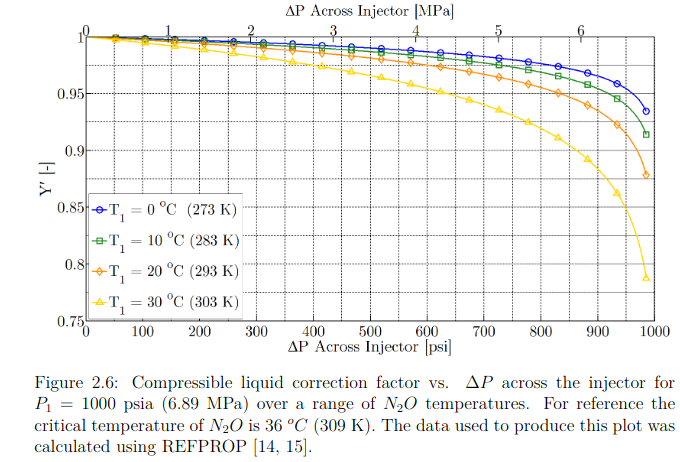

In [ ]:



m_PG = Cd*A2*np.sqrt()

# GOX/paraffin

Designed nozzle throat diameter: 9.95 mm

Final Chamber Pressure: 10.00 bar
Average Thrust: 108.67 N
Burn Time: 42.54 s
Total Oxidizer Used: 1.702 kg


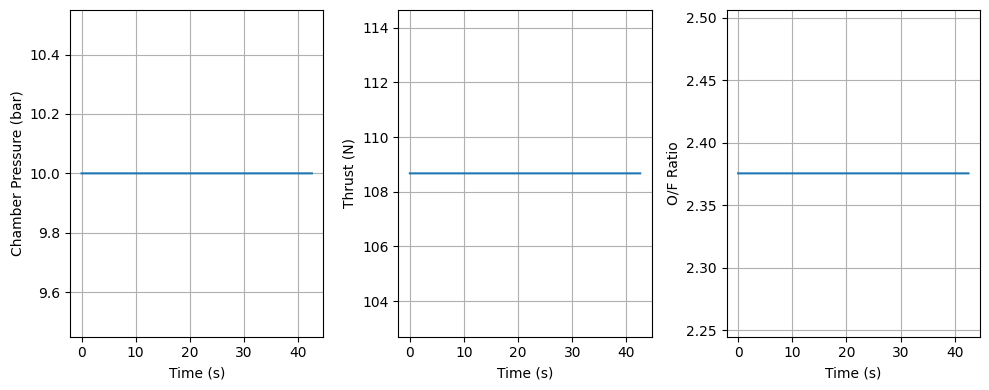

In [ ]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

# --- Constants ---
pi = np.pi

# --- System Parameters ---
P_comb = 10e5  # [Pa] TARGET CHAMBER PRESSURE (10 bar)
r2 = 0.05      # [m] Maximum port radius (100 mm diameter)
r1 = 0.01      # [m] Initial port radius (20 mm diameter)
l = 0.10       # [m] Grain length (10 cm)

# --- Fuel Properties ---
d = 950        # [kg/m^3] Paraffin density

# --- Gas Properties ---
R = 8.314      # [J/mol·K]
k = 1.22       # [-] Specific heat ratio (GOX/paraffin)
M = 0.024      # [kg/mol] Exhaust gas molecular weight

# --- Regression Parameters (GOX/wax) ---
a = 2.5e-4     # [m/s]
n = 0.5       # [-]

# --- Oxidizer Flow ---
mdot_ox = 0.04  # [kg/s] Constant oxidizer flow

# --- Simulation Setup ---
dt = 0.01       # [s] Time step
t_current = 0.0
mox = 0.0       # [kg] Total oxidizer consumed

# --- Data Storage ---
F = []          # [N] Thrust
r = []          # [cm] Port radius
t = []          # [s] Time
p_hist = []     # [Pa] Chamber pressure
OF_ratio = []   # [-] O/F ratio

# --- Pre-calculate Initial Throat Area ---
# Initial fuel flow calculation
G_ox_initial = mdot_ox / (pi * r1**2)
r_dot_initial = a * (G_ox_initial**n)
mdot_f_initial = 2 * pi * r1 * l * d * r_dot_initial
mdot_total_initial = mdot_ox + mdot_f_initial

# Combustion properties
T1 = 2800  # [K]
R_specific = R / M
c_star = sqrt(R_specific * T1) / (k * ((2/(k+1))**((k+1)/(2*(k-1)))))
A_throat = (mdot_total_initial * c_star) / P_comb  # Critical throat area

print(f"Designed nozzle throat diameter: {2*sqrt(A_throat/pi)*1000:.2f} mm")

# --- Main Simulation Loop ---
while r1 < r2:
    # 1. Regression rate
    G_ox = mdot_ox / (pi * r1**2)
    r_dot = a * (G_ox**n)
    dr = r_dot * dt

    # 2. Fuel mass flow
    mdot_f = 2 * pi * r1 * l * d * r_dot
    mdot_total = mdot_ox + mdot_f

    # 3. Chamber pressure
    p_current = (mdot_total * c_star) / A_throat

    # 4. Exhaust velocity
    pressure_ratio = (P_comb / 1e5)**((k-1)/k)
    v_e = sqrt( (2*k/(k-1)) * R_specific * T1 * (1 - 1/pressure_ratio) )

    # 5. Thrust
    thrust = v_e * mdot_total

    # Store data
    F.append(thrust)
    r.append(r1*100)  # Convert to cm
    t.append(t_current)
    p_hist.append(p_current)
    OF_ratio.append(mdot_ox/mdot_f)

    # Update variables
    r1 += dr
    t_current += dt
    mox += mdot_ox * dt

# --- Results ---
print(f"\nFinal Chamber Pressure: {p_hist[-1]/1e5:.2f} bar")
print(f"Average Thrust: {np.mean(F):.2f} N")
print(f"Burn Time: {t_current:.2f} s")
print(f"Total Oxidizer Used: {mox:.3f} kg")

# --- Plots ---
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.plot(t, [p/1e5 for p in p_hist])
plt.xlabel('Time (s)')
plt.ylabel('Chamber Pressure (bar)')
plt.grid(True)

plt.subplot(132)
plt.plot(t, F)
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.grid(True)

plt.subplot(133)
plt.plot(t, OF_ratio)
plt.xlabel('Time (s)')
plt.ylabel('O/F Ratio')
plt.grid(True)

plt.tight_layout()
plt.show()


1.8049999999999835


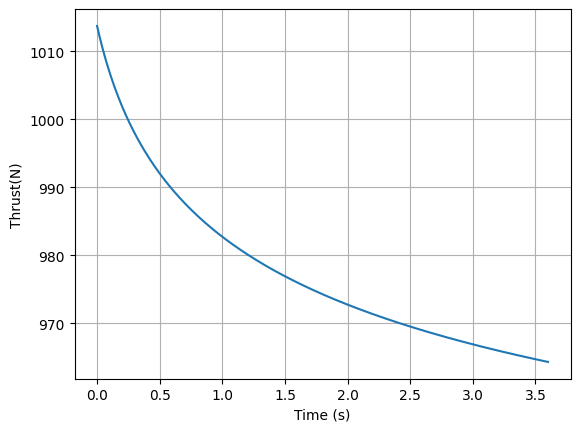

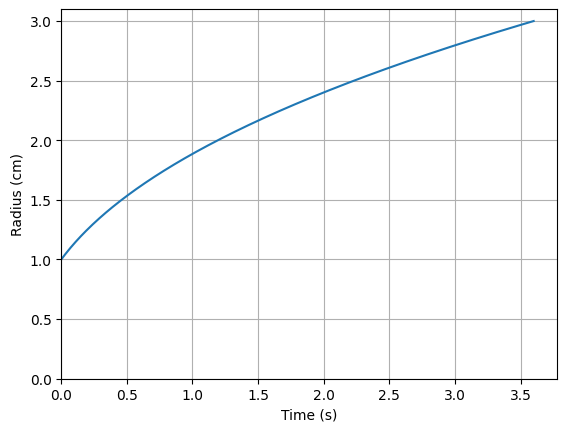

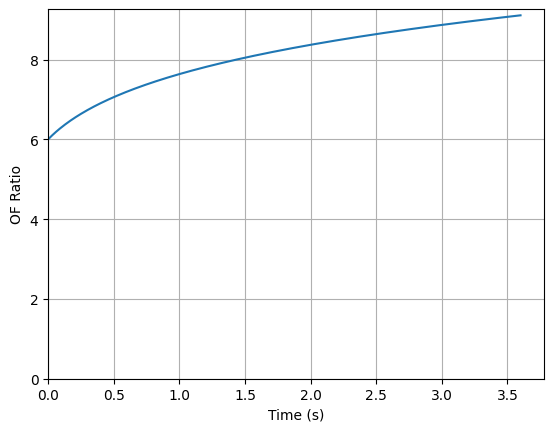

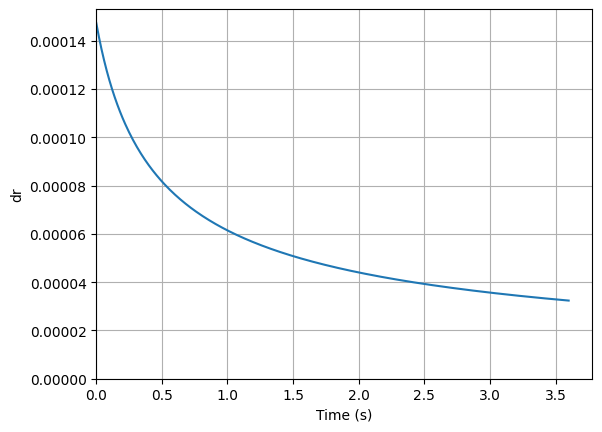

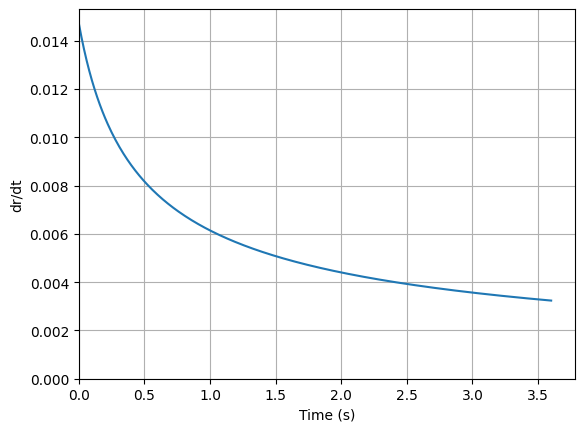

In [ ]:
## HISTORIC CODE, DO NOT EDIT! ##
## you dare not edit this code ##

import numpy as np
from math import sqrt
pi = np.pi

r2 = 0.03 #max possible diameter, airframe bolega
r1 = 0.01 #1cm
l = 0.1 # 10cm
d = 900 #kg/m3 density of wax

R = 8.314
k = 1.33
M = 0.02897
T1 = 3000
p2 = 1*10**5
p1 = 10*10**5
a = 0.007/1000  #chatgpt
n = 0.5    #chatgpt

a = 9.1e-5
n = 0.69

#assuming constant mass flow rate of oxidiser = mdot_ox
mdot_n2o = 0.040 #  kg/second, which is also the initial mass flow rate
mdot_ox = mdot_n2o*0.727
mdot_ox = 0.5
mox = 0
OF = 0

  #we assume that the optimal OF ratio is 7 and it will be reached when r = (r1+r2)/2 is reached
  #OF_opt = 7
  #r_av = (r1 + r2)/2
  #mdot_ox_optimal = ((pi**(n-1)/(2*l*d*a))*((r_av)**(2*n-1))/OF_opt)**(1/(n-1))
  #print(mdot_ox_optimal)

  #idk optimal looks too low. lemme try my own values
t_current = 0.0
dt = 0.01

  #relevant arrays
F = []
r = []
t = []
dr_values = []
OF_ratio = []
r_dot_values = []

for i in np.arange(0,10000,dt):
  if r1>r2:
       break

  G_ox = mdot_ox/(pi*r1**2)
  dr = (1)*dt*a*((G_ox)**n)
  #print('dr = ', dr)

  r_dot = dr/dt
  #print('r_dot = ', r_dot)
  r_dot_values.append(r_dot)



  mdot_f = 2*pi*l*d*r1*dr/dt
  v = sqrt((2*k/(k-1))*R*(T1/M)*(1-((p2/p1)**((k-1)/k))))
  #print(v)
  OF = mdot_ox/mdot_f
  #print('mdotf = ', 2*d*l*a*(mdot_ox**n)/((pi**(n-1))*r1**(2*n - 1)))
  #print('mdot f= ', 2*pi*l*d*r1*dr/dt)
    #print(OF)

  Fi = (mdot_ox + 2*d*l*a*(mdot_ox**n)/((pi**(n-1))*r1**(2*n - 1)))*v
    #print(Fi)

  F.append(Fi)
  r.append(100*r1)            #note that r is now in cm
  t.append(t_current)
  OF_ratio.append(OF)

  dr_values.append(dr)
  r1 += dr
  t_current += dt
#print(r1)
#print(t_current)
#print(f"{r1:.3}")


  mox += mdot_ox*dt


print(mox)


import matplotlib.pyplot as plt
import numpy as np

plt.plot(t,F)
plt.xlabel("Time (s)")
plt.ylabel("Thrust(N)")
#plt.xlim(0)
#plt.ylim(0)
plt.grid(True)
plt.show()

plt.plot(t,r)
plt.xlabel("Time (s)")
plt.ylabel("Radius (cm)")
plt.xlim(0)
plt.ylim(0)
plt.grid(True)
plt.show()

plt.plot(t,OF_ratio)
plt.xlabel("Time (s)")
plt.ylabel("OF Ratio")
plt.xlim(0)
plt.ylim(0)
plt.grid(True)
plt.show()

plt.plot(t,dr_values)
plt.xlabel("Time (s)")
plt.ylabel("dr")
plt.xlim(0)
plt.ylim(0)
plt.grid(True)
plt.show()

plt.plot(t,r_dot_values)
plt.xlabel("Time (s)")
plt.ylabel("dr/dt")
plt.xlim(0)
plt.ylim(0)
plt.grid(True)
plt.show()




